In [1]:
pip install xgboost lightgbm catboost optuna

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.


In [2]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns

from scipy.stats import rankdata
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import optuna 

s3 = boto3.resource('s3')
bucket_name = 'analytics-data-science-competitions'
bucket = s3.Bucket(bucket_name)

file_key_1 = 'Tabular-Playground-Series/PS-S3/Ep7/train.csv'
file_key_2 = 'Tabular-Playground-Series/PS-S3/Ep7/test.csv'
file_key_3 = 'Tabular-Playground-Series/PS-S3/Ep7/sample_submission.csv'

bucket_object_1 = bucket.Object(file_key_1)
file_object_1 = bucket_object_1.get()
file_content_stream_1 = file_object_1.get('Body')

bucket_object_2 = bucket.Object(file_key_2)
file_object_2 = bucket_object_2.get()
file_content_stream_2 = file_object_2.get('Body')

bucket_object_3 = bucket.Object(file_key_3)
file_object_3 = bucket_object_3.get()
file_content_stream_3 = file_object_3.get('Body')

## Reading data files
train = pd.read_csv(file_content_stream_1)
test = pd.read_csv(file_content_stream_2)
submission = pd.read_csv(file_content_stream_3)

## Fixing dates (https://www.kaggle.com/competitions/playground-series-s3e7/discussion/386655)
train['arrival_year_month'] = pd.to_datetime(train['arrival_year'].astype(str) + train['arrival_month'].astype(str), format = '%Y%m')
test['arrival_year_month'] = pd.to_datetime(test['arrival_year'].astype(str) + test['arrival_month'].astype(str), format = '%Y%m')

train.loc[train.arrival_date > train.arrival_year_month.dt.days_in_month, 'arrival_date'] = train.arrival_year_month.dt.days_in_month
test.loc[test.arrival_date > test.arrival_year_month.dt.days_in_month, 'arrival_date'] = test.arrival_year_month.dt.days_in_month

train.drop(columns = 'arrival_year_month', inplace = True)
test.drop(columns = 'arrival_year_month', inplace = True)

train['low_price_flag'] = np.where(train['avg_price_per_room'] < 30, 1, 0)
train['segment_0'] = np.where(train['market_segment_type'] == 0, 1, 0)
train['segment_1'] = np.where(train['market_segment_type'] == 1, 1, 0)
train['total_guests'] = train['no_of_adults'] + train['no_of_children']
train['stay_length'] = train['no_of_weekend_nights'] + train['no_of_week_nights']
train['stay_during_weekend'] = np.where(train['no_of_weekend_nights'] > 0, 1, 0)
train['quarter_1'] = np.where(train['arrival_month'] <= 3, 1, 0)
train['quarter_2'] = np.where(((train['arrival_month'] >= 4) & (train['arrival_month'] <= 6)), 1, 0)
train['quarter_3'] = np.where(((train['arrival_month'] >= 7) & (train['arrival_month'] <= 9)), 1, 0)
train['quarter_4'] = np.where(train['arrival_month'] >= 10, 1, 0)
train['segment_0_feature_1'] = np.where(((train['market_segment_type'] == 0) & (train['lead_time'] <= 90)), 1, 0)
train['segment_0_feature_2'] = np.where(((train['market_segment_type'] == 0) & (train['avg_price_per_room'] > 98)), 1, 0)
train['segment_1_feature_1'] = np.where(((train['market_segment_type'] == 1) & (train['no_of_special_requests'] == 0)), 1, 0)
train['segment_1_feature_2'] = np.where(((train['market_segment_type'] == 1) & (train['no_of_special_requests'] > 0) & (train['lead_time'] <= 150)), 1, 0)
train['segment_0_year_flag'] = np.where(((train['market_segment_type'] == 0) & (train['arrival_year'] == 2018)), 1, 0)
train['segment_1_year_flag'] = np.where(((train['market_segment_type'] == 1) & (train['arrival_year'] == 2018)), 1, 0)
train['price_lead_time_flag'] = np.where(((train['avg_price_per_room'] > 100) & (train['lead_time'] > 150)), 1, 0)

test['low_price_flag'] = np.where(test['avg_price_per_room'] < 30, 1, 0)
test['segment_0'] = np.where(test['market_segment_type'] == 0, 1, 0)
test['segment_1'] = np.where(test['market_segment_type'] == 1, 1, 0)
test['total_guests'] = test['no_of_adults'] + test['no_of_children']
test['stay_length'] = test['no_of_weekend_nights'] + test['no_of_week_nights']
test['stay_during_weekend'] = np.where(test['no_of_weekend_nights'] > 0, 1, 0)
test['quarter_1'] = np.where(test['arrival_month'] <= 3, 1, 0)
test['quarter_2'] = np.where(((test['arrival_month'] >= 4) & (test['arrival_month'] <= 6)), 1, 0)
test['quarter_3'] = np.where(((test['arrival_month'] >= 7) & (test['arrival_month'] <= 9)), 1, 0)
test['quarter_4'] = np.where(test['arrival_month'] >= 10, 1, 0)
test['segment_0_feature_1'] = np.where(((test['market_segment_type'] == 0) & (test['lead_time'] <= 90)), 1, 0)
test['segment_0_feature_2'] = np.where(((test['market_segment_type'] == 0) & (test['avg_price_per_room'] > 98)), 1, 0)
test['segment_1_feature_1'] = np.where(((test['market_segment_type'] == 1) & (test['no_of_special_requests'] == 0)), 1, 0)
test['segment_1_feature_2'] = np.where(((test['market_segment_type'] == 1) & (test['no_of_special_requests'] > 0) & (test['lead_time'] <= 150)), 1, 0)
test['segment_0_year_flag'] = np.where(((test['market_segment_type'] == 0) & (test['arrival_year'] == 2018)), 1, 0)
test['segment_1_year_flag'] = np.where(((test['market_segment_type'] == 1) & (test['arrival_year'] == 2018)), 1, 0)
test['price_lead_time_flag'] = np.where(((test['avg_price_per_room'] > 100) & (test['lead_time'] > 150)), 1, 0)

In [3]:
train_lgb = train.copy()
test_lgb = test.copy()

# X = train_lgb[['avg_price_per_room', 'lead_time', 'segment_0', 'segment_1', 'total_guests', 'stay_length', 'stay_during_weekend', 'quarter_1', 'quarter_2', 'quarter_3', 'quarter_4', 'segment_0_feature_1', 'segment_0_feature_2', 'segment_1_feature_1', 'segment_1_feature_2', 'segment_0_year_flag', 'segment_1_year_flag']]
# Y = train_lgb['booking_status']

# test_lgb = test_lgb[['avg_price_per_room', 'lead_time', 'segment_0', 'segment_1', 'total_guests', 'stay_length', 'stay_during_weekend', 'quarter_1', 'quarter_2', 'quarter_3', 'quarter_4', 'segment_0_feature_1', 'segment_0_feature_2', 'segment_1_feature_1', 'segment_1_feature_2', 'segment_0_year_flag', 'segment_1_year_flag']]

X = train_lgb[['avg_price_per_room', 'lead_time', 'total_guests', 'stay_length', 'segment_0_feature_1', 'segment_1_feature_1']]
Y = train_lgb['booking_status']

test_lgb = test_lgb[['avg_price_per_room', 'lead_time', 'total_guests', 'stay_length', 'segment_0_feature_1', 'segment_1_feature_1']]

# Optuna Optimization

In [6]:
class Objective:

    def __init__(self, seed):
        # Hold this implementation specific arguments as the fields of the class.
        self.seed = seed

    def __call__(self, trial):
        ## Parameters to be evaluated
        param = dict(objective = 'binary:logistic',
                     eval_metric = 'auc',
                     tree_method = 'hist', 
                     max_depth = trial.suggest_int('max_depth', 2, 10),
                     learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1, log = True),
                     n_estimators = trial.suggest_int('n_estimators', 30, 10000),
                     gamma = trial.suggest_float('gamma', 0, 10),
                     min_child_weight = trial.suggest_int('min_child_weight', 1, 100),
                     colsample_bytree = trial.suggest_float('colsample_bytree', 0.2, 0.9),
                     subsample = trial.suggest_float('subsample', 0.2, 0.9)
                    )

        scores = []
        
        skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = self.seed)
#         skf = KFold(n_splits = 5, shuffle = True, random_state = self.seed)

        for train_idx, valid_idx in skf.split(X, Y):

            X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
            Y_train , Y_valid = Y.iloc[train_idx] , Y.iloc[valid_idx]

            model = XGBClassifier(**param).fit(X_train, Y_train)

#             preds_train = model.predict(X_train)
            preds_valid = model.predict_proba(X_valid)[:, 1]

            score = roc_auc_score(Y_valid, preds_valid)
            scores.append(score)
            
        return np.mean(scores)
    
## Defining number of runs and seed
RUNS = 50
SEED = 42
N_TRIALS = 50

# Execute an optimization
study = optuna.create_study(direction = 'maximize')
study.optimize(Objective(SEED), n_trials = N_TRIALS)

[I 2023-02-18 01:52:42,702] A new study created in memory with name: no-name-5607a85b-4098-4851-a8fa-af6ae787fb13
[I 2023-02-18 01:52:58,765] Trial 0 finished with value: 0.8607521764245396 and parameters: {'max_depth': 10, 'learning_rate': 0.014486541942411337, 'n_estimators': 6505, 'gamma': 8.098912358016099, 'min_child_weight': 93, 'colsample_bytree': 0.34511160455761014, 'subsample': 0.6612297503582053}. Best is trial 0 with value: 0.8607521764245396.
[I 2023-02-18 01:53:23,775] Trial 1 finished with value: 0.8402302030302374 and parameters: {'max_depth': 2, 'learning_rate': 0.00027579380032116273, 'n_estimators': 8043, 'gamma': 1.1137166307976887, 'min_child_weight': 29, 'colsample_bytree': 0.28948555352624455, 'subsample': 0.6725597532530161}. Best is trial 0 with value: 0.8607521764245396.
[I 2023-02-18 01:53:35,466] Trial 2 finished with value: 0.8655299897454529 and parameters: {'max_depth': 10, 'learning_rate': 0.02573892421576156, 'n_estimators': 2632, 'gamma': 5.20900373871

In [7]:
study.best_trial.values

[0.8785283656464296]

In [8]:
study.best_trial.params

{'max_depth': 9,
 'learning_rate': 0.02034965867512702,
 'n_estimators': 7842,
 'gamma': 1.5968349443319794,
 'min_child_weight': 15,
 'colsample_bytree': 0.5611157723628909,
 'subsample': 0.4630289732218028}

# Cross Validation

In [13]:
XGB_cv_scores, roc_auc_scores, XGB_imp = list(), list(), list()
preds = list()

## Running 5 times CV
for i in range(5):
    
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
                
        ## Building RF model
        XGB_md = XGBClassifier(tree_method = 'hist',
                               colsample_bytree = 0.5611157723628909, 
                               gamma = 1.5968349443319794, 
                               learning_rate = 0.02034965867512702, 
                               max_depth = 9, 
                               min_child_weight = 15, 
                               n_estimators = 7842, 
                               subsample = 0.4630289732218028).fit(X_train, Y_train)
        XGB_imp.append(XGB_md.feature_importances_)
        
        ## Predicting on X_test and test
        XGB_pred_1 = XGB_md.predict_proba(X_test)[:, 1]
        XGB_pred_2 = XGB_md.predict_proba(test_lgb)[:, 1]
        
        ## Computing roc-auc score
        roc_auc_scores.append(roc_auc_score(Y_test, XGB_pred_1))
        preds.append(XGB_pred_2)

    XGB_cv_scores.append(np.mean(roc_auc_scores))
    
XGB_cv_score = np.mean(XGB_cv_scores)    
print('The average oof roc-auc score over 5-folds (run 5 times) is:', XGB_cv_score)

The average oof roc-auc score over 5-folds (run 5 times) is: 0.8785283656464296


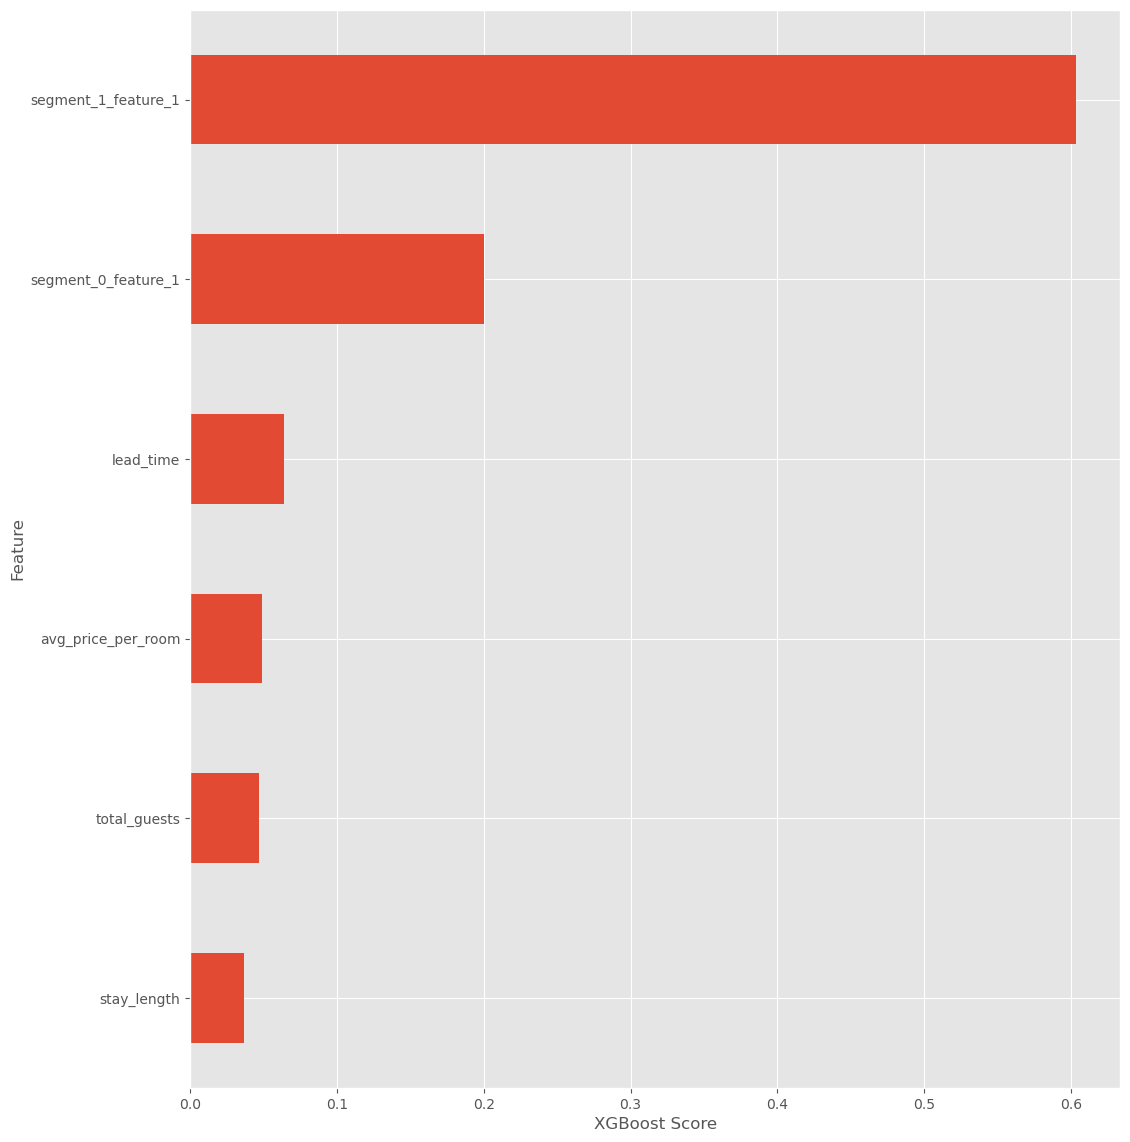

In [15]:
plt.figure(figsize = (12, 14))
pd.DataFrame(XGB_imp, columns = X.columns).apply(np.mean, axis = 0).sort_values().plot(kind = 'barh');
plt.xlabel('XGBoost Score')
plt.ylabel('Feature')
plt.show();

In [16]:
XGB_preds_test = pd.DataFrame(preds).apply(np.mean, axis = 0)

submission['booking_status'] = XGB_preds_test
submission.head()

,id,booking_status
0,42100,0.248543
1,42101,0.260800
2,42102,0.125405
3,42103,0.036110
4,42104,0.510280


In [17]:
submission.to_csv('XGB_6_features_optuna_submission.csv', index = False)